#Multi-label prediction with Planet Amazon dataset

Mount my Google Drive

* For backup
* For storage
* For file transfer

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir="/content/gdrive/My drive"
base_dir=root_dir+"fastai-v3"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Import some libraries and modules for performing some operation and matplotlib for plotting the graph

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

#Getting the data
We need to download planet dataset, which is available on kaggle. [Kaggle API](https://github.com/Kaggle/kaggle-api) is useful to you if you want to join a competition or use other Kaggle datasets .

First we will need to install Kaggle API

In [5]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


Kaggle provides python based downloading tool which we can use to download.
* Login to kaggle and click on your profile picture
* Click on My Account and scroll down until you found button name Create New API
* Click on it and download kaggle.json
* Upload file in your notebook's working directory and hit the below two commands

In [0]:
# For Linux or Mac use these two commands
!mkdir -p ~/.kaggle/

In [0]:
!mv kaggle.json ~/.kaggle/

In [0]:
# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle


Now we can download the data [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/overview)
* **first need to go to its main page and accept its rules**
* Hit the below two commands
* If you get **403 forbidden** error, then you haven't accepted rules yet.
* Don't close accept rules tab

In [10]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [11]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

100% 598M/600M [00:03<00:00, 228MB/s]
100% 600M/600M [00:03<00:00, 173MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 60.3MB/s]


To extract the content of file we'll need 7zip  or run "sudo apt install p7zip-full" in your terminal

In [0]:
!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

#Multiclassification
We have multiple labels for each file, so we can't have different folder for each images to lable it. So kaggle provide .CSV file that has each filename along with list of all labels

We can read that .CSV file using pandas library

In [13]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


So we want to turn this into something that we can use to modeling, so object which we use to modeling, that object is of databunch class.

[Data Block API](https://docs.fast.ai/data_block.html) :- Getting your data into a from that you can get it into a model, we were doing this using some factory methods, but these method was not that flexible. Sometimes we want more flexibility hence data block api make each decision separately

To put this in a DataBunch while using the data block API, we then need to using ImageList, which will make proper loss function to deal with multiple classes

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

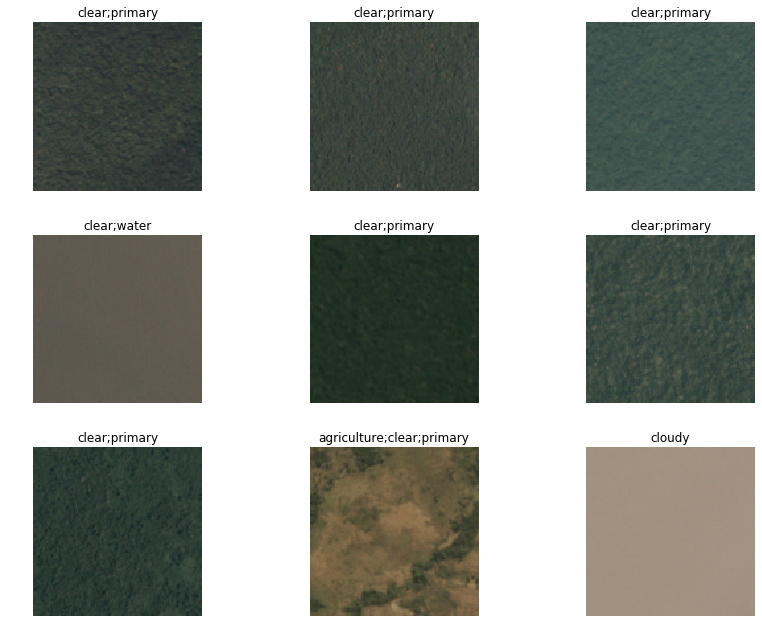

In [17]:
data.show_batch(rows=3, figsize=(12,9))

Now create the learner using the same function we used in Lesson 1

We are using resent50 now , but the matrics are little different we use accuracy_thresh instead of accuracy

In [0]:
arch = models.resnet50

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 156980715.93it/s]


We are using LR Finder to pick good learning rate

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Plot the graph

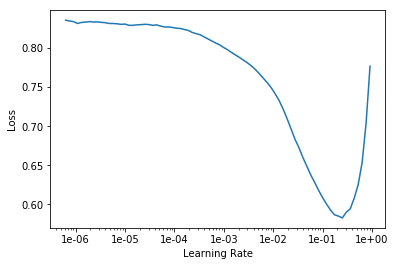

In [21]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [23]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124532,0.108793,0.946358,0.906040,02:40
1,0.112387,0.099351,0.956843,0.913438,02:35
2,0.101925,0.092107,0.953755,0.921243,02:34
3,0.095692,0.087952,0.956618,0.923359,02:34
4,0.091013,0.087004,0.956306,0.924792,02:34


Now save the model

In [0]:
learn.save('stage-1-rn50')

Now unfreeze the model

In [0]:
learn.unfreeze()

Again find the **Learning Rate** and plot the graph

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


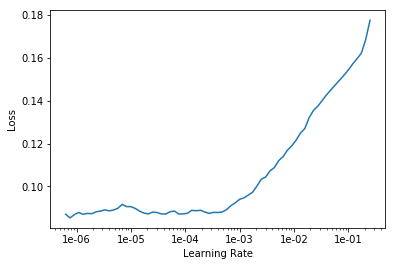

In [27]:
learn.lr_find()
learn.recorder.plot()

So as our graph show it goes back to the 10x so we are using "1e-5" for 1st half of slice.

And for the 2nd half of slice we divide Learning Rate by 5

In [28]:
learn.fit_one_cycle(5,slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095989,0.090393,0.955070,0.921853,02:43
1,0.096033,0.089131,0.954555,0.921254,02:45
2,0.091838,0.087782,0.958667,0.926040,02:44
3,0.082336,0.083014,0.957752,0.928161,02:44
4,0.081696,0.082646,0.958805,0.928620,02:45


In [0]:
learn.save('stage-2-rn50')

Now our fbeta is 0.929100, so if we want to increase the fbeta then we have to increase the size of databunch.

Previously we were using size of databunch is 128 now we will use 256 as a size of databunch

In [30]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


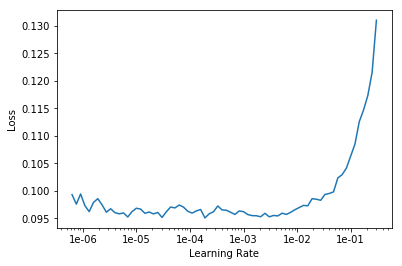

In [32]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [34]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087486,0.084570,0.958435,0.927758,05:32
1,0.086952,0.084285,0.955870,0.927600,05:30
2,0.084951,0.083516,0.958282,0.927599,05:30
3,0.082233,0.081673,0.958290,0.929666,05:30
4,0.078160,0.080903,0.959198,0.930410,05:30


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084217,0.082941,0.959678,0.929534,07:29
1,0.086373,0.084174,0.953036,0.927390,07:27
2,0.083011,0.082637,0.957178,0.927938,07:27
3,0.080866,0.080564,0.958885,0.931853,07:27
4,0.076837,0.080773,0.960099,0.930688,07:28


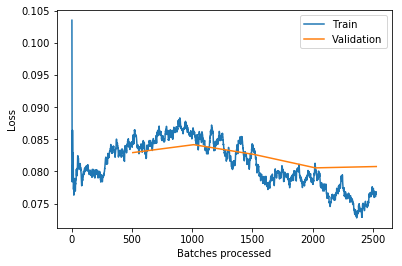

In [38]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.export()